In [2]:
import numpy as np
import matplotlib.pyplot as plt
from generation_parameters import get_params
from db_config import DBConfig
from scipy.io import loadmat
import os
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Audio
import mat73

import pyroomacoustics as pra
from pyroomacoustics import directivities as dr
from pyroomacoustics.experimental.rt60 import measure_rt60

import tau_loading

In [3]:
#(r, azi, ele) in m/deg
m1_coords = [.042, 45, 35]
m2_coords = [.042, -45, -35]
m3_coords = [.042, 135, -35]
m4_coords = [.042, -135, 35]


m1_dir = dr.CardioidFamily(
    orientation=dr.DirectionVector(azimuth=45, colatitude=55, degrees=True),
    pattern_enum=dr.DirectivityPattern.HYPERCARDIOID,
)

m2_dir = dr.CardioidFamily(
    orientation=dr.DirectionVector(azimuth=-45, colatitude=125, degrees=True),
    pattern_enum=dr.DirectivityPattern.HYPERCARDIOID,
)

m3_dir = dr.CardioidFamily(
    orientation=dr.DirectionVector(azimuth=135, colatitude=125, degrees=True),
    pattern_enum=dr.DirectivityPattern.HYPERCARDIOID,
)

m4_dir = dr.CardioidFamily(
    orientation=dr.DirectionVector(azimuth=-135, colatitude=55, degrees=True),
    pattern_enum=dr.DirectivityPattern.HYPERCARDIOID,
)

mic_coords = [m1_coords, m2_coords, m3_coords, m4_coords]
mic_dirs = [m1_dir, m2_dir, m3_dir, m4_dir]

In [4]:
# The desired reverberation time and dimensions of the room
rt60 = 0.5  # seconds
room_dim = [.1, .1, .1]  # meters

# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60, room_dim)

# Create the room
room = pra.ShoeBox(
    room_dim, fs=16000, materials=pra.Material(e_absorption), max_order=max_order
)

In [5]:
mic_loc_center = np.array([0.05, 0.05, 0.05])
mic_locs = np.empty((0,3))
for coord in mic_coords:
    rad, azi, ele = coord
    azi = azi * 2 * np.pi / 360
    ele = ele * 2 * np.pi / 360
    x_offset = rad * np.cos(azi) * np.cos(ele)
    y_offset = rad * np.sin(azi) * np.cos(ele)
    z_offset = rad * np.sin(ele)
    mic_loc = mic_loc_center + np.array([x_offset, y_offset, z_offset])
    mic_locs = np.vstack([mic_locs,mic_loc])
    

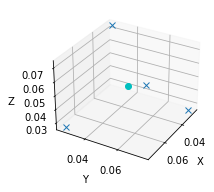

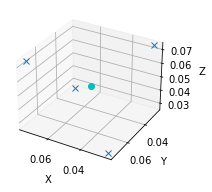

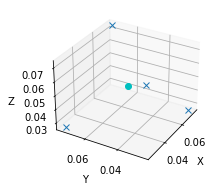

In [6]:
for cam_azi in [30, 120, 210]:
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(projection='3d')

    ax.plot(mic_loc_center[0], mic_loc_center[1], mic_loc_center[2], marker='o', color='c',\
                linestyle='none', label='Mic Array Center')
    ax.plot(mic_locs[:,0], mic_locs[:,1], mic_locs[:,2], marker='x', \
                linestyle='none', label='Mic Positions')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=30, azim=cam_azi)

In [6]:
#load dbconfig
# use parameter set defined by user
task_id = '1' 
params = get_params(task_id)

### Create database config based on params (e.g. filelist name etc.)
db_config = DBConfig(params)

SET: 1
USING DEFAULT PARAMETERS FOR NIGENS DATA

	db_name: nigens
	rirpath: /scratch/ci411/TAU_SRIR_DB/TAU-SRIR_DB
	mixturepath: /scratch/ci411/DCASE_GEN/mixtures/nigens_1
	noisepath: /scratch/ci411/TAU_SRIR_DB/TAU-SNoise_DB
	nb_folds: 2
	rooms2fold: [[10, 6, 1, 4, 3, 8], [9, 5, 2, 0, 0, 0]]
	db_path: /scratch/ci411/NIGENS
	max_polyphony: 3
	active_classes: [0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13]
	nb_mixtures_per_fold: [900, 300]
	mixture_duration: 60.0
	event_time_per_layer: 40.0
	audio_format: both
	obj_path: db_config_fsd.obj
	old_meta_synth: False

bomb_shelter
['close', 'far']
circular
[[2.5 5. ]]
[[0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]]
[[0.  0.  1.2]]

gym
['close', 'far']
circular
[[2.5 5. ]]
[[0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]]
[[0.  0.  1.2]]

pb132
['close', 'far']
circular
[[1.4 2.8]]
[[0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]]
[[0.  0.  1.2]]

pc226
['close', 'far']
circular
[[1.35 2.7 ]]
[[0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]]
[[0.  0.  1.2]]

sa203
['j1', 'j2', 'j3', 'j4'

In [7]:
def plot_energy_db(ax, rir, fs=24000):

    # The power of the impulse response in dB
    power = rir**2
    energy = np.cumsum(power[::-1])[::-1]  # Integration according to Schroeder

    # remove the possibly all zero tail
    i_nz = np.max(np.where(energy > 0)[0])
    energy = energy[:i_nz]
    energy_db = 10 * np.log10(energy)
    energy_db -= energy_db[0]
    ax.plot(energy_db)
    
def sample_rirs(rirs, n, t_type='circular'):
    if t_type == 'circular':
        n_traj, n_heights, L, n_ch, n_points = np.array(rirs).shape
    elif t_type == 'linear':
        n_traj = len(rirs)
        L, n_ch, n_points = rirs[0][0].shape
    output = np.empty((n, L))
    for i in range(n):
        ts = np.random.randint(n_traj)
        if t_type == 'linear':
            n_heights = len(rirs[ts])
        hs = np.random.randint(n_heights)
        if t_type == 'linear':
            L, n_ch, n_points = rirs[ts][hs].shape
        cs = np.random.randint(n_ch)
        ps = np.random.randint(n_points)
        output[i, :] = rirs[ts][hs][:, cs, ps]
    return output
    
def load_rir_sample(rir_file, db_config, n=5, t_type='circular', audio_format='mic'):
    path = db_config._rirpath + '/' + rir_file
    rirs = mat73.loadmat(path)
    rirs = rirs['rirs'][audio_format]
    sample = sample_rirs(rirs, n, t_type=t_type)
    del rirs
    return sample


In [9]:
room_list = ["bomb_shelter",
             "gym",
             "pb132",
             "pc226",
             "sa203",
             "sc203",
             "se203",
             "tb103",
             "tc352"]

mat_file_list = ['rirs_01_bomb_shelter.mat',
                 'rirs_02_gym.mat',
                 'rirs_03_pb132.mat',
                 'rirs_04_pc226.mat',
                 'rirs_05_sa203.mat',
                 'rirs_06_sc203.mat',
                 'rirs_08_se203.mat',
                 'rirs_09_tb103.mat',
                 'rirs_10_tc352.mat']

room_dim_list = [[50,50,12],
                 [26,16,9],
                 [9, 7, 4],
                 [5,4,3],
                 [20,15,6],
                 [9,7,4],
                 [15,10,4],
                 [20,15,6],
                 [5,4,3]]

idx = room_list.index('sc203')
mat_file_list[idx]

'rirs_06_sc203.mat'

In [12]:
gen_script = """#!/bin/bash

#SBATCH --job-name=rs-{room_name}
#SBATCH --nodes=1
#SBATCH --cpus-per-task=4
#SBATCH --mem=16GB
#SBATCH --time=47:59:59
#SBATCH --mail-user=chris.ick@nyu.edu
#SBATCH --export=NONE
#SBATCH --output="outputs/o_{room_name}-%j.out"

source ~/.bashrc
module purge
module load anaconda3/2020.07

conda activate s3d_env

cd /home/ci411/synth_data_generator/
python sim_room.py '{room_name}'"""

for room in room_list:
    print(gen_script.format(room_name=room))
    print()

#!/bin/bash

#SBATCH --job-name=rs-bomb_shelter
#SBATCH --nodes=1
#SBATCH --cpus-per-task=4
#SBATCH --mem=16GB
#SBATCH --time=47:59:59
#SBATCH --mail-user=chris.ick@nyu.edu
#SBATCH --export=NONE
#SBATCH --output="outputs/o_bomb_shelter-%j.out"

source ~/.bashrc
module purge
module load anaconda3/2020.07

conda activate s3d_env

cd /home/ci411/synth_data_generator/
python sim_room.py 'bomb_shelter'

#!/bin/bash

#SBATCH --job-name=rs-gym
#SBATCH --nodes=1
#SBATCH --cpus-per-task=4
#SBATCH --mem=16GB
#SBATCH --time=47:59:59
#SBATCH --mail-user=chris.ick@nyu.edu
#SBATCH --export=NONE
#SBATCH --output="outputs/o_gym-%j.out"

source ~/.bashrc
module purge
module load anaconda3/2020.07

conda activate s3d_env

cd /home/ci411/synth_data_generator/
python sim_room.py 'gym'

#!/bin/bash

#SBATCH --job-name=rs-pb132
#SBATCH --nodes=1
#SBATCH --cpus-per-task=4
#SBATCH --mem=16GB
#SBATCH --time=47:59:59
#SBATCH --mail-user=chris.ick@nyu.edu
#SBATCH --export=NONE
#SBATCH --output="outputs/o_pb132-%

Estimated rt60 is 7.3095 +/- 0.3236956904254365


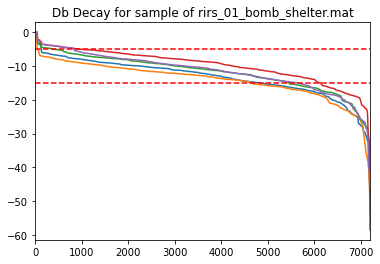

In [10]:
#Large open space in underground bomb shelter, with plastic-coated floor and rock walls. Ventilation noise.
rir_file = 'rirs_01_bomb_shelter.mat'
samples = load_rir_sample(rir_file, db_config)
fig = plt.figure()
plt.title("Db Decay for sample of {}".format(rir_file))
ax = plt.gca()
decay_db = 10
rt = []
for i in range(samples.shape[0]):
    rt.append(measure_rt60(samples[i], fs=24000, decay_db=decay_db))
    plot_energy_db(ax, samples[i,:])
plt.hlines([-5, -5-decay_db], 0, 7200, linestyle='--', color='r')
plt.xlim(0,7200)
rt = np.array(rt) * (60/decay_db)
rt_avg = np.average(rt)
rt_std = np.std(rt)
print("Estimated rt60 is {} +/- {}".format(rt_avg, rt_std))
Audio(data=samples[0], rate=24000)

room_dim = [50,50,12]
e_absorption, max_order = pra.inverse_sabine(rt_avg, room_dim)

room_bomb_shelter = pra.ShoeBox(
    room_dim, fs=24000, materials=pra.Material(e_absorption), max_order=max_order
)


In [ ]:
#Large open gym space. Ambience of people using weights and gym equipment in adjacent rooms.
rir_file = 'rirs_02_gym.mat'
samples = load_rir_sample(rir_file, db_config)
fig = plt.figure()
plt.title("Db Decay for sample of {}".format(rir_file))
ax = plt.gca()
decay_db = 15
rt = []
for i in range(samples.shape[0]):
    rt.append(measure_rt60(samples[i], fs=24000, decay_db=decay_db))
    plot_energy_db(ax, samples[i,:])
plt.hlines([-5, -5-decay_db], 0, 7200, linestyle='--', color='r')
plt.xlim(0,7200)
rt = np.array(rt) * (60/decay_db)
rt_avg = np.average(rt)
rt_std = np.std(rt)
print("Estimated rt60 is {} +/- {}".format(rt_avg, rt_std))
Audio(data=samples[0], rate=24000)

room_dim = [26,16,9]
e_absorption, max_order = pra.inverse_sabine(rt_avg, room_dim)

room_gym = pra.ShoeBox(
    room_dim, fs=24000, materials=pra.Material(e_absorption), max_order=max_order
)


Estimated rt60 is 3.436266666666666 +/- 0.15388168615313944


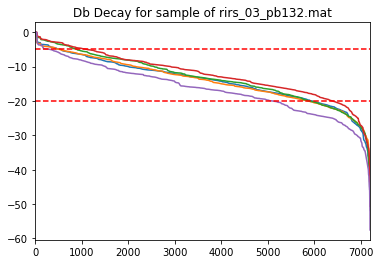

In [11]:
#Small classroom (PB132) with group work tables and carpet flooring. Ventilation noise.
rir_file = 'rirs_03_pb132.mat'
samples = load_rir_sample(rir_file, db_config)
fig = plt.figure()
plt.title("Db Decay for sample of {}".format(rir_file))
ax = plt.gca()
decay_db = 15
rt = []
for i in range(samples.shape[0]):
    rt.append(measure_rt60(samples[i], fs=24000, decay_db=decay_db))
    plot_energy_db(ax, samples[i,:])
plt.hlines([-5, -5-decay_db], 0, 7200, linestyle='--', color='r')
plt.xlim(0,7200)
rt = np.array(rt) * (60/decay_db)
rt_avg = np.average(rt)
rt_std = np.std(rt)
print("Estimated rt60 is {} +/- {}".format(rt_avg, rt_std))
Audio(data=samples[0], rate=24000)

In [18]:
paths, paths_meta, room_meta = tau_loading.load_paths(2, db_config)

room_dim = [9, 7, 4]
e_absorption, max_order = pra.inverse_sabine(rt_avg, room_dim)

room_pb132 = pra.ShoeBox(
    room_dim, fs=24000, materials=pra.Material(e_absorption), max_order=max_order
)

path = paths[0][4]
room_center = np.array([room_dim[0]/2, room_dim[1]/2, 0])
mic_center = room_meta['microphone_position'] + room_center
centered_path = path + mic_center
centered_mics = mic_locs + mic_center

room_pb132.add_microphone_array(centered_mics.T, directivity=mic_dirs)
for source in centered_path:
    room_pb132.add_source(source)

(0.0, 4.4)

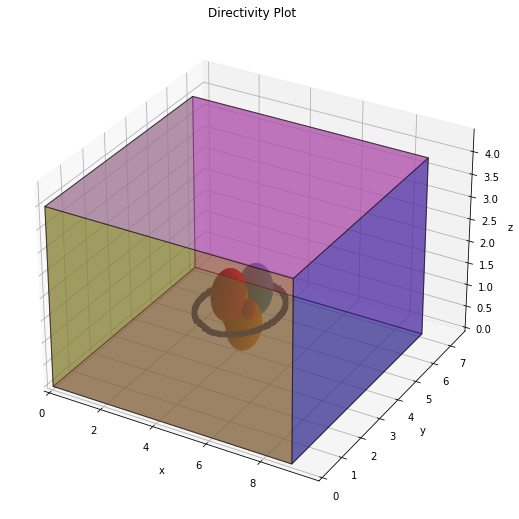

In [19]:
ax = plt.figure(figsize=(9,9)).add_subplot(projection='3d')
room_pb132.plot(ax=ax)
ax.set_xlim(0,room_dim[0]*1.1)
ax.set_ylim(0,room_dim[1]*1.1)
ax.set_zlim(0,room_dim[2]*1.1)

In [21]:
room_pb132 = pra.ShoeBox(room_dim, fs=24000, materials=pra.Material(e_absorption),
                         max_order=15, sigma2_awgn=1)

path = paths[0][4]
room_center = np.array([room_dim[0]/2, room_dim[1]/2, 0])
mic_center = room_meta['microphone_position'] + room_center
centered_mics = mic_locs + mic_center
room_pb132.add_microphone_array(centered_mics.T, directivity=mic_dirs)
centered_path = path + mic_center
for source in centered_path:
        room_pb132.add_source(source)
print("Computing...")
%timeit room_pb132.compute_rir()


Computing...
25.6 s ± 48.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
import h5py

test_load = '/scratch/ci411/DCASE_GEN/sim_rirs/bomb_shelter/bomb_shelter_t0h0.hdf5'
with h5py.File(test_load, 'r') as f:
    print(f['rirs'][0,0,:500])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [22]:
len(room_pb132.rir[0][0])

9631

In [ ]:
for i in range(4):
    for j in range(360):
        print(len(room_pb132.rir[i][j]))

In [ ]:
Audio(room_pb132.rir[0][0], rate= 24000)

In [ ]:
%load_ext autoreload

%autoreload 2

In [ ]:
#Meeting room (PC226) with hard floor and partially glass walls. Ventilation noise.
rir_file = 'rirs_04_pc226.mat'
samples = load_rir_sample(rir_file, db_config)
fig = plt.figure()
plt.title("Db Decay for sample of {}".format(rir_file))
ax = plt.gca()
decay_db = 15
rt = []
for i in range(samples.shape[0]):
    rt.append(measure_rt60(samples[i], fs=24000, decay_db=decay_db))
    plot_energy_db(ax, samples[i,:])
plt.hlines([-5, -5-decay_db], 0, 7200, linestyle='--', color='r')
plt.xlim(0,7200)
rt = np.array(rt) * (60/decay_db)
rt_avg = np.average(rt)
rt_std = np.std(rt)
print("Estimated rt60 is {} +/- {}".format(rt_avg, rt_std))
Audio(data=samples[0], rate=24000)

room_dim = [5,4,3]
e_absorption, max_order = pra.inverse_sabine(rt_avg, room_dim)

room_pc226 = pra.ShoeBox(
    room_dim, fs=24000, materials=pra.Material(e_absorption), max_order=max_order
)


In [ ]:
#Lecture hall (SA203) with inclined floor and rows of desks. Ventilation noise.
rir_file = 'rirs_05_sa203.mat'
samples = load_rir_sample(rir_file, db_config, t_type='linear')
fig = plt.figure()
plt.title("Db Decay for sample of {}".format(rir_file))
ax = plt.gca()
decay_db = 15
rt = []
for i in range(samples.shape[0]):
    rt.append(measure_rt60(samples[i], fs=24000, decay_db=decay_db))
    plot_energy_db(ax, samples[i,:])
plt.hlines([-5, -5-decay_db], 0, 7200, linestyle='--', color='r')
plt.xlim(0,7200)
rt = np.array(rt) * (60/decay_db)
rt_avg = np.average(rt)
rt_std = np.std(rt)
print("Estimated rt60 is {} +/- {}".format(rt_avg, rt_std))
Audio(data=samples[0], rate=24000)

In [ ]:
room_dim = [20,15,6]
e_absorption, max_order = pra.inverse_sabine(rt_avg, room_dim)

room_sa203 = pra.ShoeBox(
    room_dim, fs=24000, materials=pra.Material(e_absorption), max_order=max_order
)

paths, paths_meta, room_meta = tau_loading.load_paths(4, db_config)

room_center = np.array([room_dim[0]/2, room_dim[1]/2, 1])
mic_center = room_meta['microphone_position'] + room_center
centered_mics = mic_locs + mic_center

room_sa203.add_microphone_array(centered_mics.T, directivity=mic_dirs)

for i in range(paths.shape[0]):
    for j in range(paths.shape[1]):
        path = paths[i][j]
        centered_path = path + mic_center
        for source in centered_path:
            room_sa203.add_source(source)

ax = plt.figure(figsize=(9,9)).add_subplot(projection='3d')
room_sa203.plot(ax=ax)
ax.set_xlim(0,room_dim[0]*1.1)
ax.set_ylim(0,room_dim[1]*1.1)
ax.set_zlim(0,room_dim[2]*1.1)

In [ ]:
#Small classroom (SC203) with group work tables and carpet flooring. Ventilation noise.
rir_file = 'rirs_06_sc203.mat'
samples = load_rir_sample(rir_file, db_config, t_type='linear')
fig = plt.figure()
plt.title("Db Decay for sample of {}".format(rir_file))
ax = plt.gca()
decay_db = 15
rt = []
for i in range(samples.shape[0]):
    rt.append(measure_rt60(samples[i], fs=24000, decay_db=decay_db))
    plot_energy_db(ax, samples[i,:])
plt.hlines([-5, -5-decay_db], 0, 7200, linestyle='--', color='r')
plt.xlim(0,7200)
rt = np.array(rt) * (60/decay_db)
rt_avg = np.average(rt)
rt_std = np.std(rt)
print("Estimated rt60 is {} +/- {}".format(rt_avg, rt_std))
Audio(data=samples[0], rate=24000)

room_dim = [9,7,4]
e_absorption, max_order = pra.inverse_sabine(rt_avg, room_dim)

room_sc203 = pra.ShoeBox(
    room_dim, fs=24000, materials=pra.Material(e_absorption), max_order=max_order
)


In [ ]:
#Large classroom (SE203) with hard floor and rows of desks. Ventilation noise.
rir_file = 'rirs_08_se203.mat'
samples = load_rir_sample(rir_file, db_config, t_type='linear')
fig = plt.figure()
plt.title("Db Decay for sample of {}".format(rir_file))
ax = plt.gca()
decay_db = 10
rt = []
for i in range(samples.shape[0]):
    rt.append(measure_rt60(samples[i], fs=24000, decay_db=decay_db))
    plot_energy_db(ax, samples[i,:])
plt.hlines([-5, -5-decay_db], 0, 7200, linestyle='--', color='r')
plt.xlim(0,7200)
rt = np.array(rt) * (60/decay_db)
rt_avg = np.average(rt)
rt_std = np.std(rt)
print("Estimated rt60 is {} +/- {}".format(rt_avg, rt_std))
Audio(data=samples[0], rate=24000)

room_dim = [15,10,4]
e_absorption, max_order = pra.inverse_sabine(rt_avg, room_dim)

room_se203 = pra.ShoeBox(
    room_dim, fs=24000, materials=pra.Material(e_absorption), max_order=max_order
)


In [ ]:
#Lecture hall (TB103) with inclined floor and rows of desks. Ventilation noise.
rir_file = 'rirs_09_tb103.mat'
samples = load_rir_sample(rir_file, db_config, t_type='linear')
fig = plt.figure()
plt.title("Db Decay for sample of {}".format(rir_file))
ax = plt.gca()
decay_db = 15
rt = []
for i in range(samples.shape[0]):
    rt.append(measure_rt60(samples[i], fs=24000, decay_db=decay_db))
    plot_energy_db(ax, samples[i,:])
plt.hlines([-5, -5-decay_db], 0, 7200, linestyle='--', color='r')
plt.xlim(0,7200)
rt = np.array(rt) * (60/decay_db)
rt_avg = np.average(rt)
rt_std = np.std(rt)
print("Estimated rt60 is {} +/- {}".format(rt_avg, rt_std))
Audio(data=samples[0], rate=24000)

room_dim = [20,15,6]
e_absorption, max_order = pra.inverse_sabine(rt_avg, room_dim)

room_tb103 = pra.ShoeBox(
    room_dim, fs=24000, materials=pra.Material(e_absorption), max_order=max_order
)


In [ ]:
#Meeting room (TC352) with hard floor and partially glass walls. Ventilation noise.
rir_file = 'rirs_10_tc352.mat'
samples = load_rir_sample(rir_file, db_config)
fig = plt.figure()
plt.title("Db Decay for sample of {}".format(rir_file))
ax = plt.gca()
decay_db = 15
rt = []
for i in range(samples.shape[0]):
    rt.append(measure_rt60(samples[i], fs=24000, decay_db=decay_db))
    plot_energy_db(ax, samples[i,:])
plt.hlines([-5, -5-decay_db], 0, 7200, linestyle='--', color='r')
plt.xlim(0,7200)
rt = np.array(rt) * (60/decay_db)
rt_avg = np.average(rt)
rt_std = np.std(rt)
print("Estimated rt60 is {} +/- {}".format(rt_avg, rt_std))
Audio(data=samples[0], rate=24000)

room_dim = [5,4,3]
e_absorption, max_order = pra.inverse_sabine(rt_avg, room_dim)

room_tc352 = pra.ShoeBox(
    room_dim, fs=24000, materials=pra.Material(e_absorption), max_order=max_order
)
